<a href="https://colab.research.google.com/github/psukphranee/Python-Practice/blob/master/SAR_scratch_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import math
import os
import scipy.sparse as sp

#A. Pulse Train Generating Functions

```generate_LFM_Pulse(time_array, pulse_width, pulse_height, chirp_rate, carrier_frequency)```

### $P(t) = \chi_{\tau}(t) e^{j 2 \pi (f_c t + \frac{1}{2}k t^2)}$. (cite Cheney Here)

$\chi_{\tau}(t)$ piecewise function describing pulse envelope

$f_c$ = carrier frequency

$k$ = chirp rate

##0. Dummy Variables and Utility Functions
Variables used for demo's in this section.

In [2]:
def plot_train(time_absolute, time_modulus, train):

  fig, ax = plt.subplots(2,1, figsize=(20,8))
  ax[0].plot(t[0,:], train[0,:], alpha=0.5)
  ax[1].plot(t[0,:], t_mod[0,:], alpha=0.5)

  # ax[0].set_title("Pulse Envelope")
  ax[1].set_title("Verify Periodicity")
  plt.show()

In [21]:
#create time vector
t = np.linspace(0, 99, 1000).reshape(1,-1)
#signal period
PRT = 10
#prepreocess time vector to make periodic
t_mod = t % PRT

A = 1;
tau = 5;
k = .05;
f_c = .1;


##1. Pulse Envelope Train Helper Function

Generate a pulse (or pulses) of specified height and width. Pulse(s) have their left edge at time values of 0.

In [4]:
def generate_pulse_envelope(time_array, pulse_width=1, pulse_height=1):
  #this function returns pulse envelopes of tau width wide. the left edge of the envelope is located at any zeros of the time array.

  t = time_array;
  A = pulse_height;
  tau = pulse_width; 
  tau_half = tau/2;

  chi = A * (np.abs((t-tau_half)/tau_half) <= 1);

  return chi;

###a. Demo

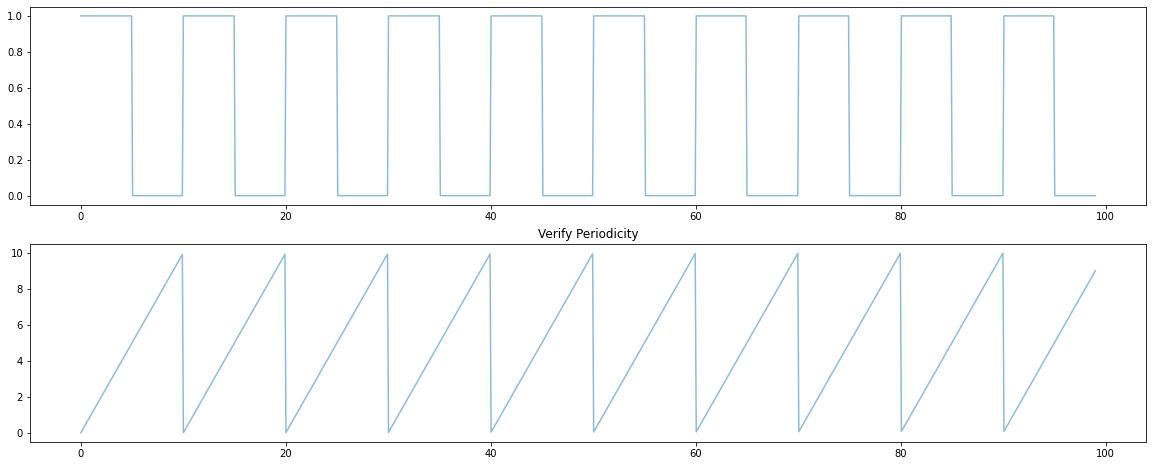

In [12]:
envelope_train = generate_pulse_envelope(t_mod, pulse_width=tau, pulse_height=A)
plot_train(t, t_mod, envelope_train)

##2. Pulse Wave Train Helper Function

In [6]:
def generate_pulse_wave(time_array, chirp_rate=1, carrier_frequency=100):
  #time ---------------
  t = time_array #expected time vector should be preprocessed before passed to this function. pulse and envelope start their sequences at times values of zeros.

  #LFM  ---------------
  k = chirp_rate
  f_c = carrier_frequency

  # #argument to be passed to exponenetial 
  exp_arg = 2j*np.pi*(f_c*t + .5*k*(t**2))
  LFM = np.exp(exp_arg);

  return LFM

###a. Demo

/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1317: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


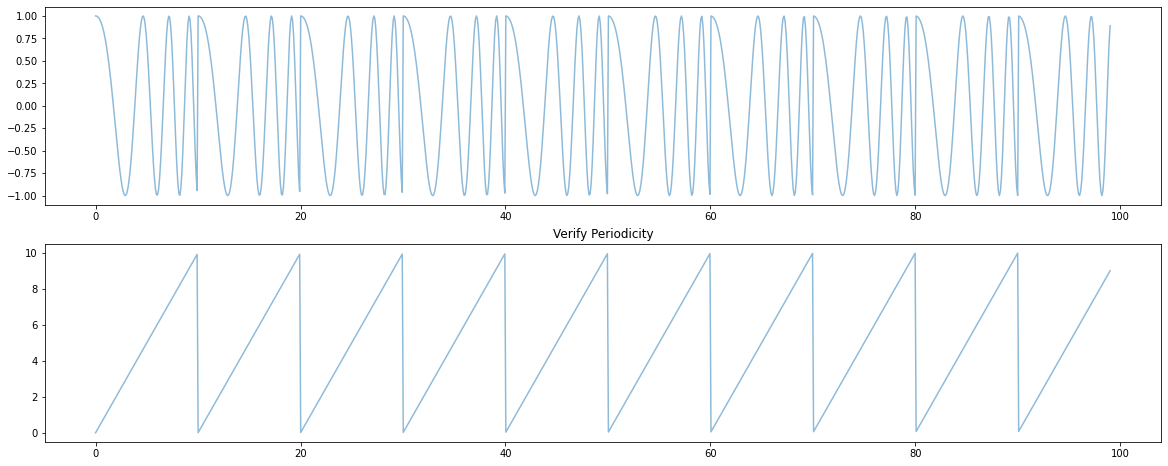

In [13]:
wave_train = generate_pulse_wave(t_mod, chirp_rate=k, carrier_frequency=f_c)
plot_train(t, t_mod, wave_train)

##3. LFM Pulse: Product of Helper Functions

In [31]:
def generate_LFM_Pulse(time_array, pulse_width=1, pulse_height=1, chirp_rate=1, carrier_frequency=100):
  
  #time ---------------
  t = time_array #expected time vector should be preprocessed before passed to this function. pulse and envelope start their sequences at times values of zeros.

  #pulse envelope  ---------------
  chi = generate_pulse_envelope(t, pulse_height=pulse_height, pulse_width=pulse_width);

  #LFM  ---------------
  k = chirp_rate
  f_c = carrier_frequency

  LFM = generate_pulse_wave(t, k, f_c)

  pulse = chi * LFM;

  return pulse

###a. Demo

/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1317: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


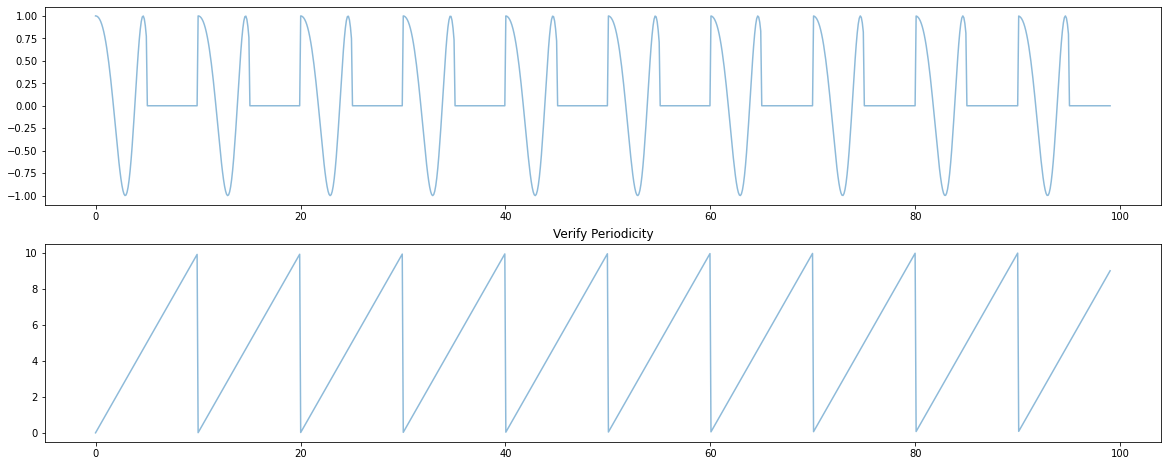

In [32]:
pulse = generate_LFM_Pulse(time_array=t_mod, pulse_width=5, pulse_height=A, chirp_rate=k, carrier_frequency=f_c)
plot_train(t, t_mod, pulse)

#B. Geometry of Problem

##1. Matrix Representing Ground Swath

a. Let a matrix of 1D represent the ground swathed. The first element represents closest to radar and final element the furthest.

* $position = [p_0, p_1, ..., p_{n-1}]$

b. Each element is associated with some travel time. 

* $t_{travel} = [t_0, t_1, ..., t_{n-1}]$

c. For the purposes on convolution, we only care about the differences in travel time and therefore make them relative to $t_0$. $t_{travel} ⇒ t_{delay}$.

* $t_{delay} = [0, \Delta t_1, \Delta t_2, ..., \Delta t_{n-1}]$

d. Simplify by assuming time differences are all the same, $\Delta t$. Therefore,

* $t_{delay} = [0, \Delta t, 2 Δ t, ..., (n-1) Δt]$

In [9]:
ground